***Sale Prediction And Forecasting Using Stacked LSTM***


*import the necessary packages*

In [201]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import datetime


*read and preprocess the data*


In [ ]:
 
df1 =  pd.read_csv ('/content/DCL-Assessment/train.csv')
df1.drop(['date'], 1, inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))




*Splitting the Sale data into Train and Test sets*


In [203]:
training_size=int(len(df1)*0.64)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


print(training_size,test_size)


# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----10
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)
 


# reshape 
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


72 42


*Define LSTM*

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
lstm_31 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


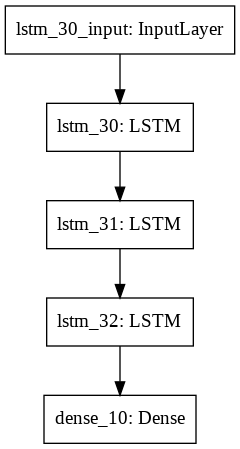

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.utils import plot_model
from keras import backend as K
K.set_epsilon(1) 

# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                        K.epsilon(),
                                        None))
    return 100. * K.mean(diff, axis=-1)


model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss=mean_absolute_percentage_error,optimizer='adam')

print(model.summary())
plot_model(model)

*Training*

In [205]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=300,batch_size=16,verbose=1)

Epoch 1/300
4/4 [==============================] - 6s 412ms/step - loss: 52.9817 - val_loss: 33.0526
Epoch 2/300
4/4 [==============================] - 0s 28ms/step - loss: 40.3631 - val_loss: 21.9776
Epoch 3/300
4/4 [==============================] - 0s 29ms/step - loss: 18.4150 - val_loss: 28.6048
Epoch 4/300
4/4 [==============================] - 0s 29ms/step - loss: 22.8694 - val_loss: 26.0377
Epoch 5/300
4/4 [==============================] - 0s 28ms/step - loss: 17.1984 - val_loss: 17.2401
Epoch 6/300
4/4 [==============================] - 0s 28ms/step - loss: 18.4831 - val_loss: 17.9291
Epoch 7/300
4/4 [==============================] - 0s 32ms/step - loss: 15.3570 - val_loss: 17.1653
Epoch 8/300
4/4 [==============================] - 0s 29ms/step - loss: 15.4735 - val_loss: 20.3488
Epoch 9/300
4/4 [==============================] - 0s 29ms/step - loss: 13.9314 - val_loss: 23.9125
Epoch 10/300
4/4 [==============================] - 0s 28ms/step - loss: 15.0600 - val_loss: 19.444

*Prediction*

In [206]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics

print('Train RMSE:', math.sqrt(mean_squared_error(y_train,train_predict)))


### Test Data RMSE
print('Test RMSE:', math.sqrt(mean_squared_error(y_test,test_predict)))


    

Train RMSE: 424.61166860102946
Test RMSE: 394.1183379837813


*Visualize Predictions*

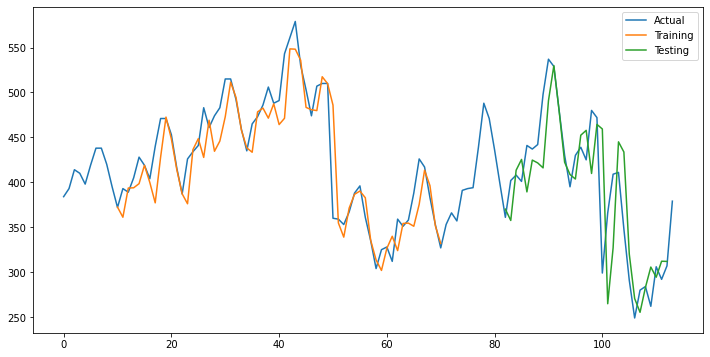

In [207]:


# shift train predictions for plotting
look_back=10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize = (12, 6))
plt.plot(scaler.inverse_transform(df1), label='Actual')
plt.plot(trainPredictPlot,  label='Training')
plt.plot(testPredictPlot, label='Testing')
plt.legend(loc='best')
plt.show()




*Predictions for Next 30 Days*


In [211]:


# demonstrate prediction for next 30  = 3 * 10  days

from numpy import array
lentest = len(test_data)
x_input=test_data[lentest - look_back:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

final = []

for i in range(3):
  print(100 * '-')

  lst_output=[]
  n_steps=look_back
  i=0
  while(i<look_back):
      
      if(len(temp_input)>look_back):
          x_input=np.array(temp_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          final.append(yhat)
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          lst_output.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps,1))
          yhat = model.predict(x_input, verbose=0)
          final.append(yhat)
          temp_input.extend(yhat[0].tolist())
          lst_output.extend(yhat.tolist())
          i=i+1

  new = []
  for i in lst_output:
    new.append(i[0])

  temp_input = new

      

----------------------------------------------------------------------------------------------------
1 day input [0.12727273 0.         0.09393939 0.10606061 0.03939394 0.17272727
 0.13030303 0.17575758 0.39393939 0.35504597]
1 day output [[0.36247957]]
2 day input [0.         0.09393939 0.10606061 0.03939394 0.17272727 0.13030303
 0.17575758 0.39393939 0.35504597 0.36247957]
2 day output [[0.32573244]]
3 day input [0.09393939 0.10606061 0.03939394 0.17272727 0.13030303 0.17575758
 0.39393939 0.35504597 0.36247957 0.32573244]
3 day output [[0.2840386]]
4 day input [0.10606061 0.03939394 0.17272727 0.13030303 0.17575758 0.39393939
 0.35504597 0.36247957 0.32573244 0.2840386 ]
4 day output [[0.25562644]]
5 day input [0.03939394 0.17272727 0.13030303 0.17575758 0.39393939 0.35504597
 0.36247957 0.32573244 0.2840386  0.25562644]
5 day output [[0.24620159]]
6 day input [0.17272727 0.13030303 0.17575758 0.39393939 0.35504597 0.36247957
 0.32573244 0.2840386  0.25562644 0.24620159]
6 day outp

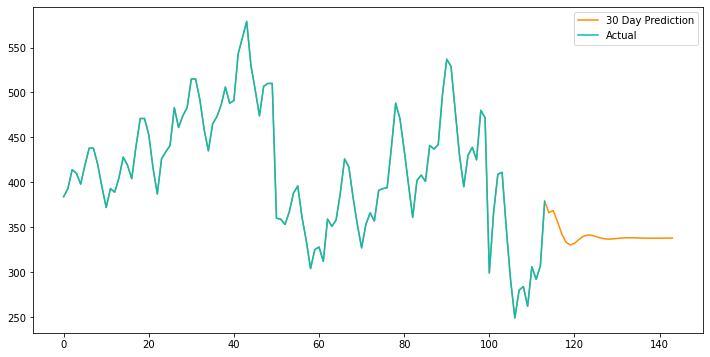

In [212]:
day_new=np.arange(0,114)
day_pred=np.arange(0, 144)

# shift train predictions for plotting
look_back=10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize = (12, 6))
final = np.array(final)
final = final.reshape(-1, 1)
f = np.concatenate((df1, final))
# plt.plot(day_new,scaler.inverse_transform(df1))
plt.plot(day_pred ,scaler.inverse_transform(f), label='30 Day Prediction', color = 'darkorange')
plt.plot(scaler.inverse_transform(df1), label='Actual', color ='c' )
plt.legend(loc='best')
plt.show()


*Fill The Output.csv*

In [165]:
output = pd.read_csv('/content/DCL-Assessment/output.csv')
output['sale'] = scaler.inverse_transform(final)
output.to_csv('/content/DCL-Assessment/results.csv', index=False)